**Proyecto Final - Redes Neuronales Convolucionales - Butterfly Image Classification**

**Autores: Cristian Andrés Velandia Montaño - 20241595012**

**Mayer Santiago Beltran Romero - 20241695002**

El conjunto de datos incluye 75 clases diferentes de mariposas. El conjunto de datos contiene más de 1.000 imágenes etiquetadas, incluidas las imágenes de validación. Cada imagen pertenece a una sola categoría de mariposas.

Las etiquetas de cada imagen se guardan en Training_set.csv.

El archivo Testing_set.csv contiene los nombres de las imágenes de la carpeta de prueba, que debe predecir la etiqueta y enviar a Data Sprint 107 - Clasificación de imágenes de mariposas.

Traducción realizada con la versión gratuita del traductor DeepL.com

In [1]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user() # Authenticate the user before attempting to mount the drive
drive.mount('/content/drive/') # Mount the drive


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/butterflies

/content/drive/MyDrive/butterflies


In [3]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git

%cd GroundingDINO/

!pip install -q -e .

!pip install supervision

fatal: destination path 'GroundingDINO' already exists and is not an empty directory.
/content/drive/MyDrive/butterflies/GroundingDINO
  Preparing metadata (setup.py) ... done


In [4]:
!mkdir weights

!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth -P weights

mkdir: cannot create directory ‘weights’: File exists


In [5]:
!dir


build	    docker_test.py    groundingdino.egg-info  requirements.txt	weights
demo	    environment.yaml  LICENSE		      setup.py
Dockerfile  groundingdino     README.md		      test.ipynb


In [6]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

model = load_model("/content/drive/MyDrive/butterflies/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py",
     "weights/groundingdino_swint_ogc.pth")

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


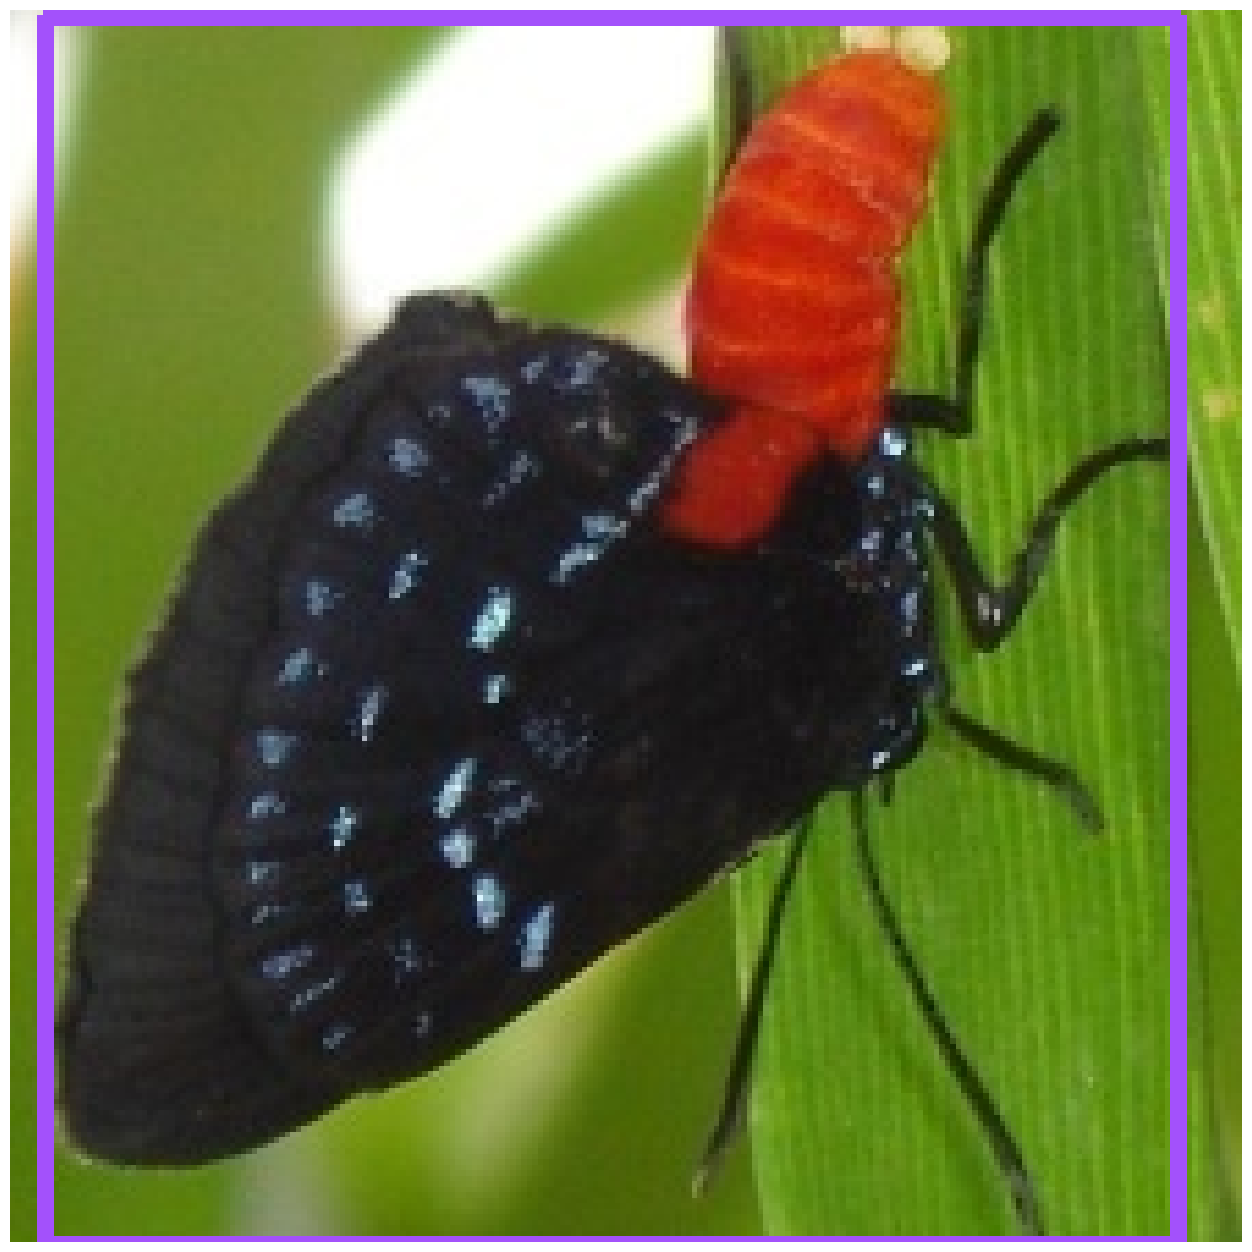

In [7]:
import os
import supervision as sv

# Configuración
image_path = "/content/drive/MyDrive/butterflies/train/Image_6499.jpg"
text = "Butterfly"
BOX_THRESHOLD = 0.26
TEXT_THRESHOLD = 0.30

# Cargar imagen
image_source, image = load_image(image_path)

# Realizar predicción
boxes, logits, phrases = predict(
    model=model,
    image=image,
    caption=text,
    box_threshold=BOX_THRESHOLD,
    text_threshold=TEXT_THRESHOLD,
    device='cuda'
)


annotated_frame = annotate(
    image_source=image_source,
    boxes=boxes,
    logits=logits,
    phrases=phrases)

sv.plot_image(annotated_frame,(16,16))

In [8]:
# Convertir predicciones al formato YOLO
def convert_to_yolo_format(boxes, image_width, image_height, class_id=0):
    yolo_labels = []
    for box in boxes:
        x_min, y_min, x_max, y_max = box

        # Calcular coordenadas normalizadas
        center_x = (x_min + x_max) / 2 / image_width
        center_y = (y_min + y_max) / 2 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height

        # Formato YOLO: class_id center_x center_y width height
        yolo_labels.append(f"{class_id} {center_x} {center_y} {width} {height}")

    return yolo_labels

# Dimensiones de la imagen
image_height, image_width = image.shape[:2]

# Generar etiquetas YOLO
yolo_labels = convert_to_yolo_format(boxes, image_width, image_height)

# Imprimir cada línea generada
print("Líneas generadas para el archivo YOLO:")
for line in yolo_labels:
    print(line)

# Guardar etiquetas en un archivo .txt
output_dir = "/content/drive/MyDrive/butterflies/yolo_labels/"
os.makedirs(output_dir, exist_ok=True)

# Crear archivo .txt con el nombre de la imagen
output_file = os.path.join(output_dir, os.path.basename(image_path).replace('.jpg', '.txt'))
with open(output_file, 'w') as f:
    f.write('\n'.join(yolo_labels))

print(f"Etiquetas YOLO guardadas en: {output_file}")

Líneas generadas para el archivo YOLO:
0 0.0008808199781924486 0.2494667023420334 0.0005409869481809437 0.16311539709568024
Etiquetas YOLO guardadas en: /content/drive/MyDrive/butterflies/yolo_labels/Image_6499.txt


In [9]:
import locale
locale.getpreferredencoding = lambda: 'UTF-8'
%cd /content/drive/MyDrive/butterflies
!git clone https://github.com/facebookresearch/segment-anything.git
%cd segment-anything
!pip install -e .

/content/drive/MyDrive/butterflies
fatal: destination path 'segment-anything' already exists and is not an empty directory.
/content/drive/MyDrive/butterflies/segment-anything
Obtaining file:///content/drive/MyDrive/butterflies/segment-anything
  Preparing metadata (setup.py) ... done
  Attempting uninstall: segment_anything
    Found existing installation: segment_anything 1.0
    Uninstalling segment_anything-1.0:
      Successfully uninstalled segment_anything-1.0
  Running setup.py develop for segment_anything


In [10]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /content/drive/MyDrive/butterflies/

--2024-11-21 03:08:29--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.4.45, 13.225.4.39, 13.225.4.116, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.4.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/drive/MyDrive/butterflies/sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G  56.8MB/s    in 54s     

2024-11-21 03:09:23 (45.5 MB/s) - ‘/content/drive/MyDrive/butterflies/sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]



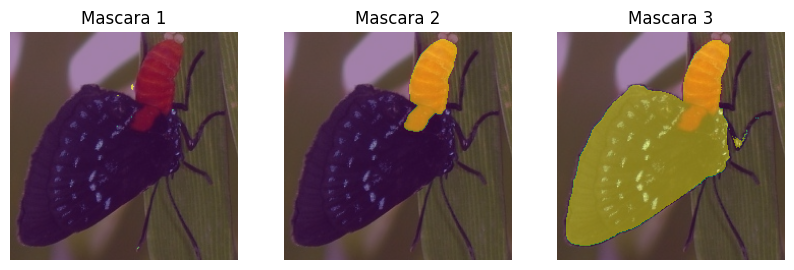

Máscara guardada en: /content/drive/MyDrive/butterflies/masks//mask_1.png
Máscara guardada en: /content/drive/MyDrive/butterflies/masks//mask_2.png
Máscara guardada en: /content/drive/MyDrive/butterflies/masks//mask_3.png


In [11]:
import torch
from segment_anything import SamPredictor, sam_model_registry
from segment_anything.utils.transforms import ResizeLongestSide
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Cargar modelo SAM
sam_checkpoint = "/content/drive/MyDrive/butterflies/sam_vit_h_4b8939.pth"  # Cambia según tu modelo descargado
model_type = "vit_h"  # Modelo grande; también puedes usar 'vit_l' o 'vit_b'
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda" if torch.cuda.is_available() else "cpu"
sam.to(device)

# Inicializar el predictor
predictor = SamPredictor(sam)

# Cargar la imagen
image_path = "/content/drive/MyDrive/butterflies/train/Image_6499.jpg"
image = np.array(Image.open(image_path).convert("RGB"))

# Configurar la imagen para el predictor
predictor.set_image(image)

# Generar máscaras basadas en puntos
input_point = np.array([[400, 300]])  # Coordenadas del punto (x, y)
input_label = np.array([1])  # Etiqueta 1 indica el objeto
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True  # Generar múltiples máscaras posibles
)

# Visualizar las máscaras
plt.figure(figsize=(10, 10))
for i, mask in enumerate(masks):
    plt.subplot(1, len(masks), i + 1)
    plt.imshow(image)
    plt.imshow(mask, alpha=0.5)  # Superponer la máscara en la imagen
    plt.title(f"Mascara {i+1}")
    plt.axis("off")
plt.show()

# Guardar las máscaras como imágenes binarias
output_dir = "/content/drive/MyDrive/butterflies/masks/"
os.makedirs(output_dir, exist_ok=True)

for i, mask in enumerate(masks):
    mask_image = Image.fromarray((mask * 255).astype(np.uint8))  # Convertir a escala de grises
    mask_image.save(f"{output_dir}/mask_{i+1}.png")
    print(f"Máscara guardada en: {output_dir}/mask_{i+1}.png")